# Source and Sink contributions

In [2]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.colors
from mpl_toolkits.basemap import Basemap, cm
import cmocean
import netCDF4 as nc
from itertools import compress
import datetime as dt

%matplotlib notebook

Load domain mask etc.

In [3]:
imin, imax = 1480, 2180
jmin, jmax = 160, 800

isize = imax-imin
jsize = jmax-jmin

In [4]:
mask  = nc.Dataset('/ocean/brogalla/GEOTRACES/ariane_runs/ANHA12_Ariane_mesh.nc')
tmask = np.array(mask.variables['tmask'])[0,:,imin:imax,jmin:jmax]
land_mask = np.ma.masked_where((tmask[:,:,:] > 0.1), tmask[:,:,:]) 

In [5]:
ref   = nc.Dataset('/data/brogalla/run_storage/spin-up0-low-case/ANHA12_EXH006_2002_monthly.nc',  'r')
lons  = np.array(ref.variables['nav_lon'])
lats  = np.array(ref.variables['nav_lat'])
depth = np.array(ref.variables['deptht'])

Load Mn model results

In [6]:
def load_results(folder_ref):
    
    months  = ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12']
    dmn_riv = np.empty((12,isize,jsize))   ; dmn_sed = np.empty((12,isize,jsize)); 
    dmn_atm = np.empty((12,isize,jsize))   ; dmn_ice = np.empty((12,isize,jsize));
    dmn_sedice = np.empty((12,isize,jsize));
    dmn_red = np.empty((12,50,isize,jsize)); dmn_oxi = np.empty((12,50,isize,jsize))
    
    i=0
    for month in months:
        file        = 'ANHA12_EXH006_1m_20020101_20021231_comp_2002'+month+'-2002'+month+'.nc'
        ref_monthly = nc.Dataset(folder_ref+file)
        
        dmn_riv[i,:,:]    = np.array(ref_monthly.variables['dmnriv'])[0,:,:]
        dmn_sed[i,:,:]    = np.array(ref_monthly.variables['dmnsed'])[0,:,:]
        dmn_sedice[i,:,:] = np.array(ref_monthly.variables['dmnsedice'])[0,:,:]
        dmn_atm[i,:,:]    = np.array(ref_monthly.variables['dmnatm'])[0,:,:]
        dmn_ice[i,:,:]    = np.array(ref_monthly.variables['dmnice'])[0,:,:]
        dmn_red[i,:,:,:]  = np.array(ref_monthly.variables['dmnred'])[0,:,:,:]
        dmn_oxi[i,:,:,:]  = np.array(ref_monthly.variables['dmnoxi'])[0,:,:,:]
        i+=1
    
    tmask_surf    = np.empty(dmn_riv.shape)
    tmask_surf[:] = tmask[0,:,:]
    tmask_full    = np.empty(dmn_red.shape)
    tmask_full[:] = tmask
    
    # Mask points on land:
    dmn_mriv    = np.ma.masked_where((tmask_surf < 0.1), dmn_riv); 
    dmn_msed    = np.ma.masked_where((tmask_surf < 0.1), dmn_sed)
    dmn_msedice = np.ma.masked_where((tmask_surf < 0.1), dmn_sedice)
    dmn_matm    = np.ma.masked_where((tmask_surf < 0.1), dmn_atm)
    dmn_mice    = np.ma.masked_where((tmask_surf < 0.1), dmn_ice)
    dmn_mred    = np.ma.masked_where((tmask_full < 0.1), dmn_red)
    dmn_moxi    = np.ma.masked_where((tmask_full < 0.1), dmn_oxi)

    return dmn_mriv, dmn_msed, dmn_msedice, dmn_matm, dmn_mice, dmn_mred , dmn_moxi

In [7]:
folder_ref  = '/data/brogalla/run_storage/spin-up2-resus-change/'

In [8]:
dmn_mriv, dmn_msed, dmn_msedice, dmn_matm, dmn_mice, dmn_mred, dmn_moxi = load_results(folder_ref)

Load volume of grid cells:

In [9]:
e1t_base = np.array(mask.variables['e1t'])[0,imin:imax,jmin:jmax]
e2t_base = np.array(mask.variables['e2t'])[0,imin:imax,jmin:jmax]
e3t      = np.array(mask.variables['e3t_0'])[0,:,imin:imax,jmin:jmax]

In [10]:
e1t    = np.tile(e1t_base, (50,1,1))
e2t    = np.tile(e2t_base, (50,1,1))
volume = e1t*e2t*e3t

Calculate the moles of Mn contributed to each grid cell

In [11]:
riv    = dmn_mriv    * volume[0,:,:]
sed    = dmn_msed    * volume[0,:,:]
sedice = dmn_msedice * volume[0,:,:]
atm    = dmn_matm    * volume[0,:,:]
ice    = dmn_mice    * volume[0,:,:]
red    = dmn_mred    * volume
oxi    = dmn_moxi    * volume

Consider the surface layer specifically:

In [12]:
riv_surf    = np.sum(riv[:,:,:], axis=(1,2))   / (12*isize*jsize)
sed_surf    = np.sum(sed[:,:,:], axis=(1,2))   / (12*isize*jsize)
sedice_surf = np.sum(sedice[:,:,:], axis=(1,2))/ (12*isize*jsize)
atm_surf    = np.sum(atm[:,:,:], axis=(1,2))   / (12*isize*jsize)
ice_surf    = np.sum(ice[:,:,:], axis=(1,2))   / (12*isize*jsize)
# red_surf    = np.sum(red[:,0,:,:], axis=(1,2)) / (12*isize*jsize)
# oxi_surf    = np.sum(oxi[:,0,:,:], axis=(1,2)) / (12*isize*jsize)
red_surf    = np.sum(red[:,0:17,:,:], axis=(1,2,3)) / (12*isize*jsize*17) #PML
oxi_surf    = np.sum(oxi[:,0:17,:,:], axis=(1,2,3)) / (12*isize*jsize*17) #PML

<IPython.core.display.Javascript object>


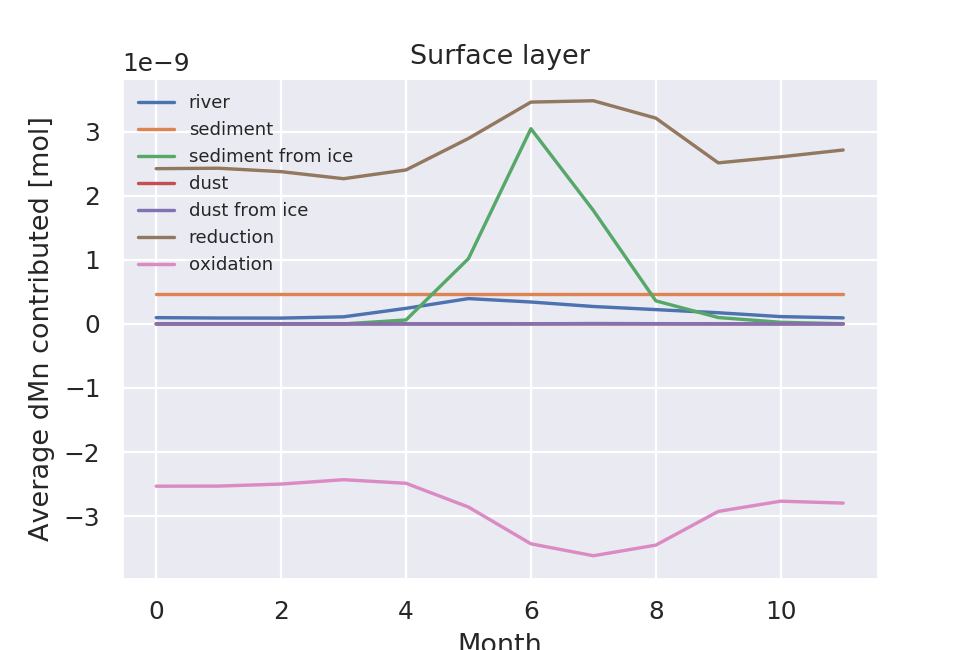

In [17]:
fig, ax = plt.subplots(1,1, figsize=(6,4))

ax.plot(riv_surf   , label='river')
ax.plot(sed_surf   , label='sediment')
ax.plot(sedice_surf, label='sediment from ice')
ax.plot(atm_surf   , label='dust')
ax.plot(ice_surf   , label='dust from ice')
ax.plot(red_surf   , label='reduction')
ax.plot(-oxi_surf  , label='oxidation')

ax.set_ylabel('Average dMn contributed [mol]')
ax.set_title('Surface layer')
ax.set_xlabel('Month')
ax.legend(fontsize=8, frameon=False, loc=2)

### Bar plots:

In [18]:
import seaborn as sns; sns.set()

In [19]:
colors = ['#ccb598', '#448d90', '#739f78', '#CC8741', '#cee7fd', '#b9c1c7']#'#CED7DE']

<IPython.core.display.Javascript object>


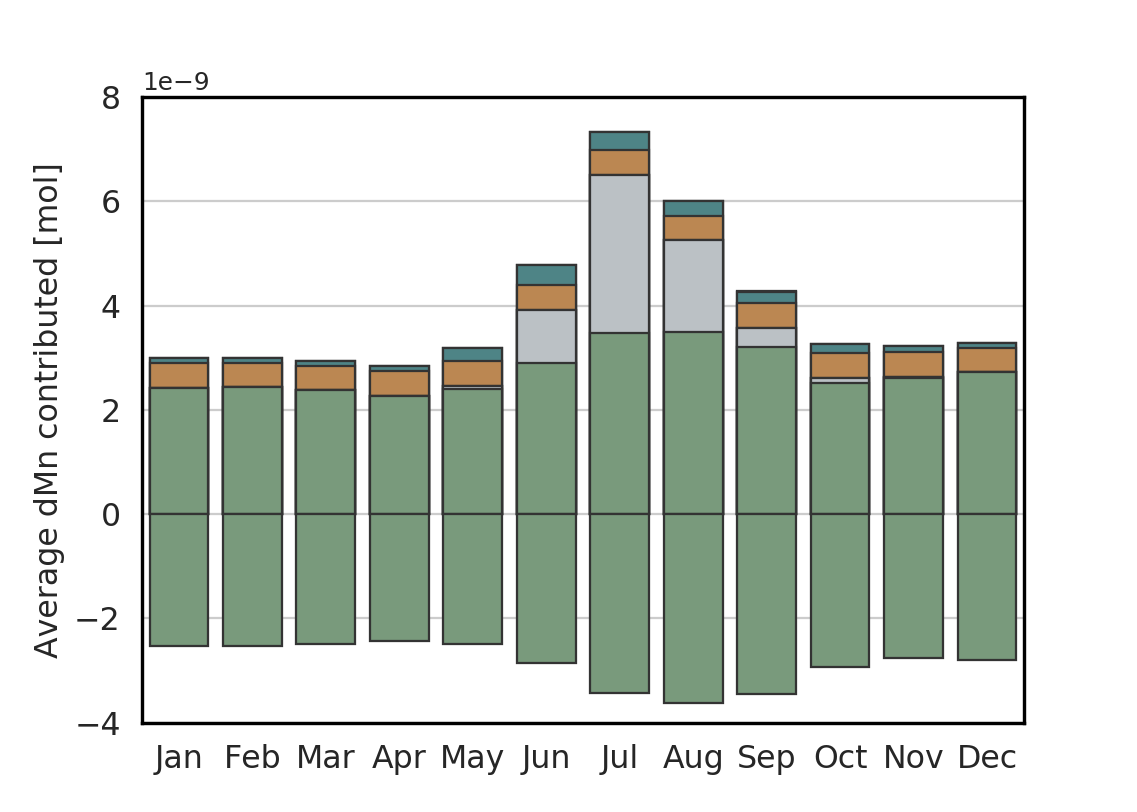

In [20]:
fig = plt.figure(figsize=(7,5))
st  = sns.axes_style("whitegrid")

with st:
    icp= sns.barplot(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'], \
                     sedice_surf+red_surf+atm_surf+sed_surf+riv_surf+ice_surf, color=colors[4], edgecolor=".2")
    rip= sns.barplot(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'], \
                     sedice_surf+red_surf+atm_surf+sed_surf+riv_surf, color=colors[1], edgecolor=".2")
    sep= sns.barplot(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'], \
                     sedice_surf+red_surf+atm_surf+sed_surf, color=colors[3], edgecolor=".2")
    dup= sns.barplot(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'], \
                     sedice_surf+red_surf+atm_surf, color=colors[0], edgecolor=".2")
    
    icp= sns.barplot(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'], \
                     sedice_surf+red_surf, color=colors[5], edgecolor=".2") 
    # Scavenging:
    scp= sns.barplot(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'], \
                     red_surf, color=colors[2], edgecolor=".2") 
    scn= sns.barplot(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'], \
                     -oxi_surf, color=colors[2], edgecolor=".2") 
    
    icp.set_ylabel('Average dMn contributed [mol]', fontsize=14)
    icp.set(ylim=(-4e-9,8e-9))
    icp.tick_params(axis='both', which='major', labelsize=14)
    icp.spines['left'].set_linewidth(1.5);   icp.spines['left'].set_color('black');
    icp.spines['bottom'].set_linewidth(1.5); icp.spines['bottom'].set_color('black');
    icp.spines['right'].set_linewidth(1.5);  icp.spines['right'].set_color('black');
    icp.spines['top'].set_linewidth(1.5);    icp.spines['top'].set_color('black');    
    
# fig.savefig('/ocean/brogalla/GEOTRACES/figures/distr-PML_src.png', bbox_inches='tight',dpi=300)

### Spatial variation in component importance:

In [21]:
def calculate_prop(dmn_on, dmn_off):
    # Input arguments:
    # - dmn_on (t,z,y,x) --- concentration of dMn with component on
    # - dmn_off(t,z,y,x) --- concentration of dMn with component off
    
    # Contribution of component at each point
    diff     = np.subtract(dmn_on, dmn_off)
    diff_pos = np.ma.where((diff > 0), diff, np.zeros_like(diff))
    diff_neg = np.ma.where((diff < 0), diff, np.zeros_like(diff))
    
    # Output:
    # - prop(t,z,y,x)  --- proportional contribution of component to simulated [dMn]
    return diff_pos, diff_neg

Sum the contribution of each model component over the course of a year

In [30]:
atm_year    = atm[:,:,:].sum(axis=1)
riv_year    = riv[:,:,:].sum(axis=1)
sed_year    = sed[:,:,:].sum(axis=1)
sedice_year = sedice[:,:,:].sum(axis=1)
ice_year    = ice[:,:,:].sum(axis=1)
red_year    = red[:,0,:,:].sum(axis=1)
oxi_year    = oxi[:,0,:,:].sum(axis=1)      

Function to find at each grid point which source component is most important (using masks):

In [42]:
def comp_importance(month, riv_prop=riv, sed_prop=sed, sedice_prop=sedice, atm_prop=atm, \
                    ice_prop=ice, red_prop=np.zeros(red[:,0,:,:].shape), output=False): # leave out oxidation since loss term
    
    # Rivers
    riv_imp = np.ma.masked_where((riv_prop[month,:,:] < sed_prop[month,:,:]), riv_prop[month,:,:])
    riv_imp = np.ma.masked_where((riv_imp[:,:] < sedice_prop[month,:,:]), riv_imp[:,:])
    riv_imp = np.ma.masked_where((riv_imp[:,:] < atm_prop[month,:,:])   , riv_imp[:,:])
    riv_imp = np.ma.masked_where((riv_imp[:,:] < ice_prop[month,:,:])   , riv_imp[:,:])
    riv_imp = np.ma.masked_where((riv_imp[:,:] < red_prop[month,:,:])   , riv_imp[:,:])

    # Sediment release from ice
    sice_imp = np.ma.masked_where((sedice_prop[month,:,:] < riv_prop[month,:,:]), sedice_prop[month,:,:])
    sice_imp = np.ma.masked_where((sice_imp[:,:] < sed_prop[month,:,:]) , sice_imp[:,:])
    sice_imp = np.ma.masked_where((sice_imp[:,:] < atm_prop[month,:,:]) , sice_imp[:,:])
    sice_imp = np.ma.masked_where((sice_imp[:,:] < ice_prop[month,:,:]) , sice_imp[:,:])
    sice_imp = np.ma.masked_where((sice_imp[:,:] < red_prop[month,:,:]) , sice_imp[:,:])
    
    # Sediment resuspension
    sed_imp = np.ma.masked_where((sed_prop[month,:,:] < riv_prop[month,:,:]), sed_prop[month,:,:])
    sed_imp = np.ma.masked_where((sed_imp[:,:] < sedice_prop[month,:,:]), sed_imp[:,:])
    sed_imp = np.ma.masked_where((sed_imp[:,:] < atm_prop[month,:,:])   , sed_imp[:,:])
    sed_imp = np.ma.masked_where((sed_imp[:,:] < ice_prop[month,:,:])   , sed_imp[:,:])
    sed_imp = np.ma.masked_where((sed_imp[:,:] < red_prop[month,:,:])   , sed_imp[:,:])

    # Reduction
    red_imp = np.ma.masked_where((red_prop[month,:,:] < sed_prop[month,:,:]), red_prop[month,:,:])
    red_imp = np.ma.masked_where((red_imp[:,:]  < sedice_prop[month,:,:]), red_imp[:,:])
    red_imp = np.ma.masked_where((red_imp[:,:]  < atm_prop[month,:,:])   , red_imp[:,:])
    red_imp = np.ma.masked_where((red_imp[:,:]  < ice_prop[month,:,:])   , red_imp[:,:])
    red_imp = np.ma.masked_where((red_imp[:,:]  < riv_prop[month,:,:])   , red_imp[:,:])

    # Dust from ice
    ice_imp = np.ma.masked_where((ice_prop[month,:,:] < sed_prop[month,:,:]), ice_prop[month,:,:])
    ice_imp = np.ma.masked_where((ice_imp[:,:]  < sedice_prop[month,:,:]), ice_imp[:,:])
    ice_imp = np.ma.masked_where((ice_imp[:,:]  < atm_prop[month,:,:])   , ice_imp[:,:])
    ice_imp = np.ma.masked_where((ice_imp[:,:]  < riv_prop[month,:,:])   , ice_imp[:,:])
    ice_imp = np.ma.masked_where((ice_imp[:,:]  < red_prop[month,:,:])   , ice_imp[:,:])

    # Dust directly from atmosphere
    atm_imp = np.ma.masked_where((atm_prop[month,:,:] < sed_prop[month,:,:]), atm_prop[month,:,:])
    atm_imp = np.ma.masked_where((atm_imp[:,:]  < sedice_prop[month,:,:]), atm_imp[:,:])
    atm_imp = np.ma.masked_where((atm_imp[:,:]  < riv_prop[month,:,:])   , atm_imp[:,:])
    atm_imp = np.ma.masked_where((atm_imp[:,:]  < ice_prop[month,:,:])   , atm_imp[:,:])
    atm_imp = np.ma.masked_where((atm_imp[:,:]  < red_prop[month,:,:])   , atm_imp[:,:])

    if output:
        print('Rivers       --- Masked values before: ', np.ma.count_masked(riv_prop[month,:,:]), ', after: ', \
          np.ma.count_masked(riv_imp[:,:]))
        print('Rivers       --- Non-masked values:    ', np.ma.count(riv_imp[:,:]))
        print('Sediment     --- Masked values before: ', np.ma.count_masked(sed_prop[month,:,:]), ', after: ', \
          np.ma.count_masked(sed_imp[:,:]))
        print('Sediment     --- Non-masked values:    ', np.ma.count(sed_imp[:,:]))
        print('Sediment ice --- Masked values before: ', np.ma.count_masked(sedice_prop[month,:,:]), ', after: ', \
        np.ma.count_masked(sice_imp[:,:]))
        print('Sediment ice --- Non-masked values:    ', np.ma.count(sice_imp[:,:]))
        print('Reduction    --- Masked values before: ', np.ma.count_masked(red_prop[month,:,:]), ', after: ', \
          np.ma.count_masked(red_imp[:,:]))
        print('Reduction    --- Non-masked values:    ', np.ma.count(red_imp[:,:]))
        print('Dust ice     --- Masked values before: ', np.ma.count_masked(ice_prop[month,:,:]), ', after: ', \
          np.ma.count_masked(ice_imp[:,:]))
        print('Dust ice     --- Non-masked values:    ', np.ma.count(ice_imp[:,:]))
        print('Dust direct  --- Masked values before: ', np.ma.count_masked(atm_prop[month,:,:]), ', after: ', \
          np.ma.count_masked(atm_imp[:,:]))
        print('Dust direct  --- Non-masked values:    ', np.ma.count(atm_imp[:,:]))

    return riv_imp, sed_imp, sice_imp, red_imp, ice_imp, atm_imp

In [43]:
riv_imp, sed_imp, sedice_imp, red_imp, ice_imp, atm_imp = comp_importance(1, output=True)

Rivers       --- Masked values before:  207530 , after:  447034
Rivers       --- Non-masked values:     966
Sediment     --- Masked values before:  207530 , after:  433308
Sediment     --- Non-masked values:     14692
Sediment ice --- Masked values before:  207530 , after:  447347
Sediment ice --- Non-masked values:     653
Reduction    --- Masked values before:  0 , after:  448000
Reduction    --- Non-masked values:     0
Dust ice     --- Masked values before:  207530 , after:  223860
Dust ice     --- Non-masked values:     224140
Dust direct  --- Masked values before:  207530 , after:  447981
Dust direct  --- Non-masked values:     19


In [44]:
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

In [45]:
def plot_year_importance(fig, ax, proj1):
    
    x, y = proj1(lons, lats)
    
    axes=[ax[0,0], ax[0,1], ax[0,2], ax[0,3], \
          ax[1,0], ax[1,1], ax[1,2], ax[1,3], \
          ax[2,0], ax[2,1], ax[2,2], ax[2,3]]
    
    for month in range(0,12):
        riv_imp, sed_imp, sice_imp, red_imp, ice_imp, atm_imp = comp_importance(month)
        
        sz = 0.1
    
        proj1.plot(x[~atm_imp.mask], y[~atm_imp.mask],'p', markersize=sz,c=colors[0], ax=axes[month]  , zorder=2)
        proj1.plot(x[~red_imp.mask], y[~red_imp.mask],'p', markersize=sz, c=colors[2], ax=axes[month] , zorder=2)
        proj1.plot(x[~sed_imp.mask], y[~sed_imp.mask],'p', markersize=sz, c=colors[3], ax=axes[month] , zorder=2)
        proj1.plot(x[~ice_imp.mask], y[~ice_imp.mask],'p', markersize=sz, c=colors[4], ax=axes[month] , zorder=2)
        proj1.plot(x[~sice_imp.mask], y[~sice_imp.mask],'p', markersize=sz, c=colors[5], ax=axes[month],zorder=2)
        proj1.plot(x[~riv_imp.mask], y[~riv_imp.mask],'p', markersize=sz, c=colors[1], ax=axes[month] , zorder=2)
        
        proj1.plot(x[-1,300:-1], y[-1,300:-1], '-w', linewidth=3, ax=axes[month])
        proj1.plot(x[0,360:500], y[0,360:500], '-w', linewidth=3, ax=axes[month])
        proj1.plot(x[150:-1,-1], y[150:-1,-1], '-w', linewidth=3, ax=axes[month])
        
        proj1.contourf(x, y, land_mask[0,:,:], vmax=0.3, ax=axes[month], \
                       cmap=matplotlib.colors.ListedColormap(["#8b7765"]), zorder=3)
        
        axes[month].set_title(months[month])
    
    return

<IPython.core.display.Javascript object>


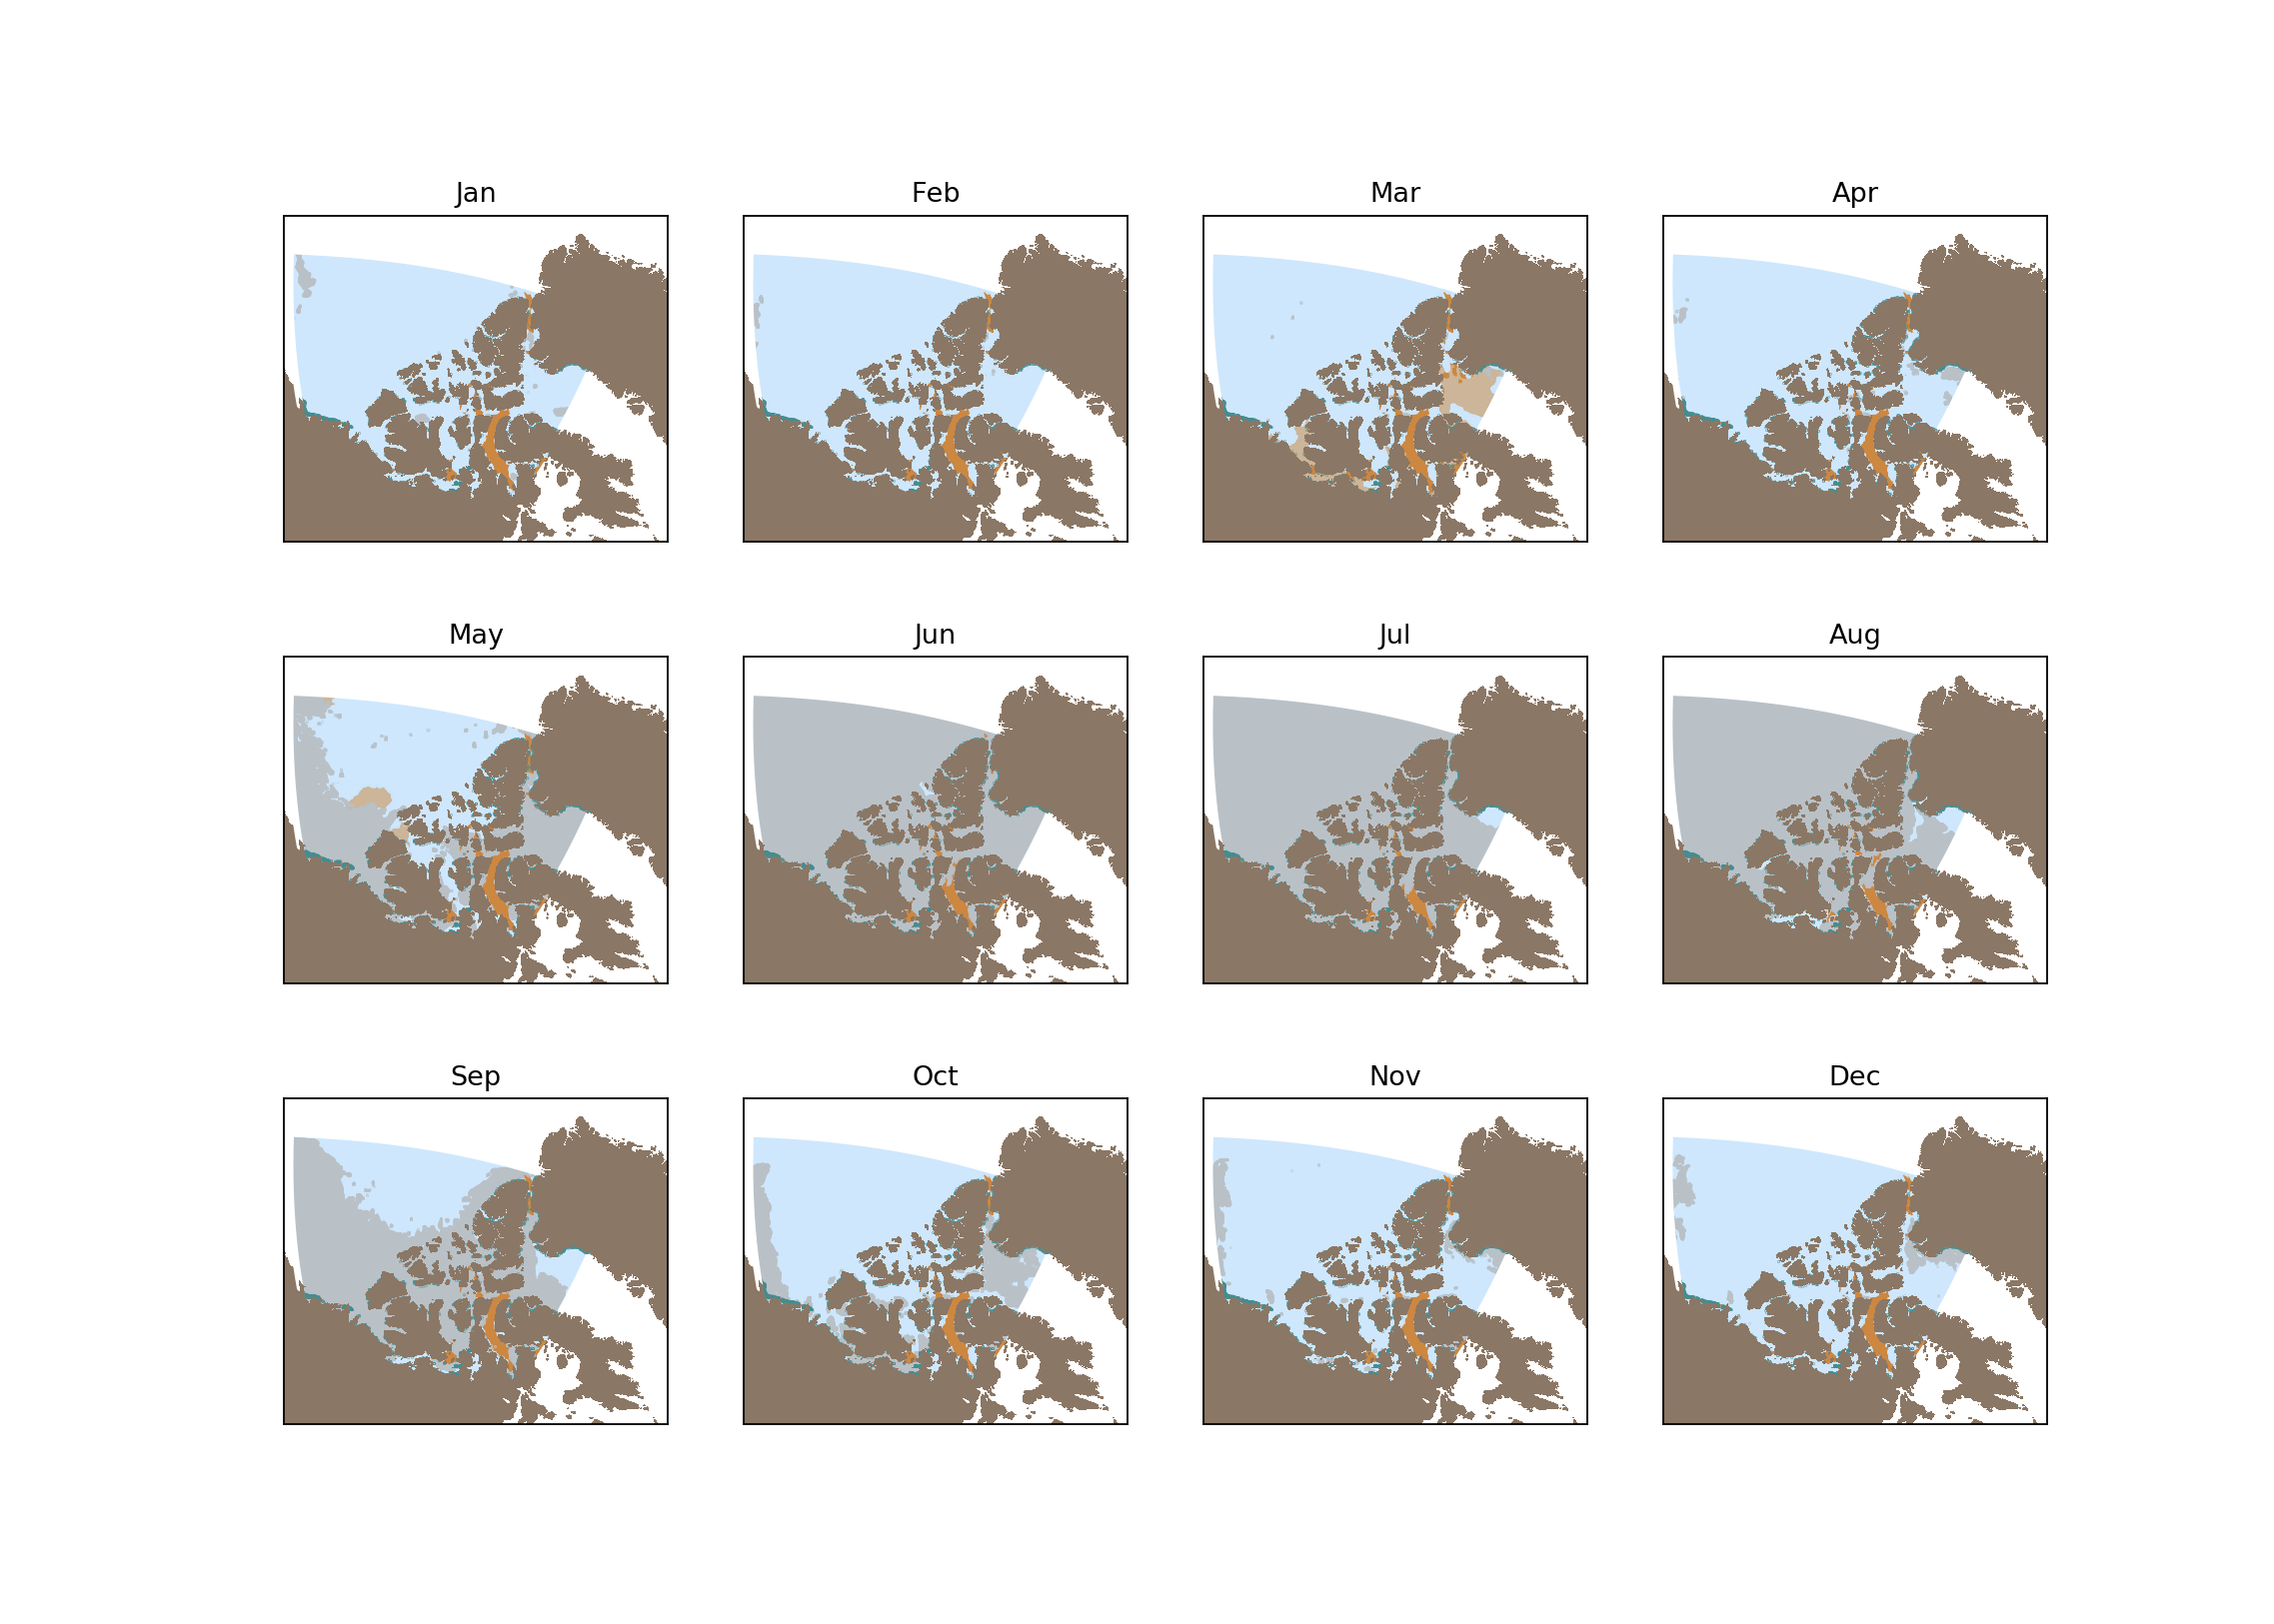

In [46]:
fig, ax, proj1 = pickle.load(open('/ocean/brogalla/GEOTRACES/pickles/surface-Mn_subplots.pickle','rb'))

plot_year_importance(fig, ax, proj1)

# proj1.plot(0,0,'.', markersize=20, c=colors[0], label='Dust from atmosphere')
# proj1.plot(0,0,'.', markersize=20, c=colors[1], label='River')
# proj1.plot(0,0,'.', markersize=20, c=colors[2], label='Scavenging')
# proj1.plot(0,0,'.', markersize=20, c=colors[3], label='Sediment')
# proj1.plot(0,0,'.', markersize=20, c=colors[4], label='Ice')

# ax[2,3].legend(loc=(1.01, 0.05), fontsize=14, frameon=False)

# fig.savefig('/ocean/brogalla/GEOTRACES/figures/seasonal-components.png', bbox_inches='tight', dpi=300)

<IPython.core.display.Javascript object>


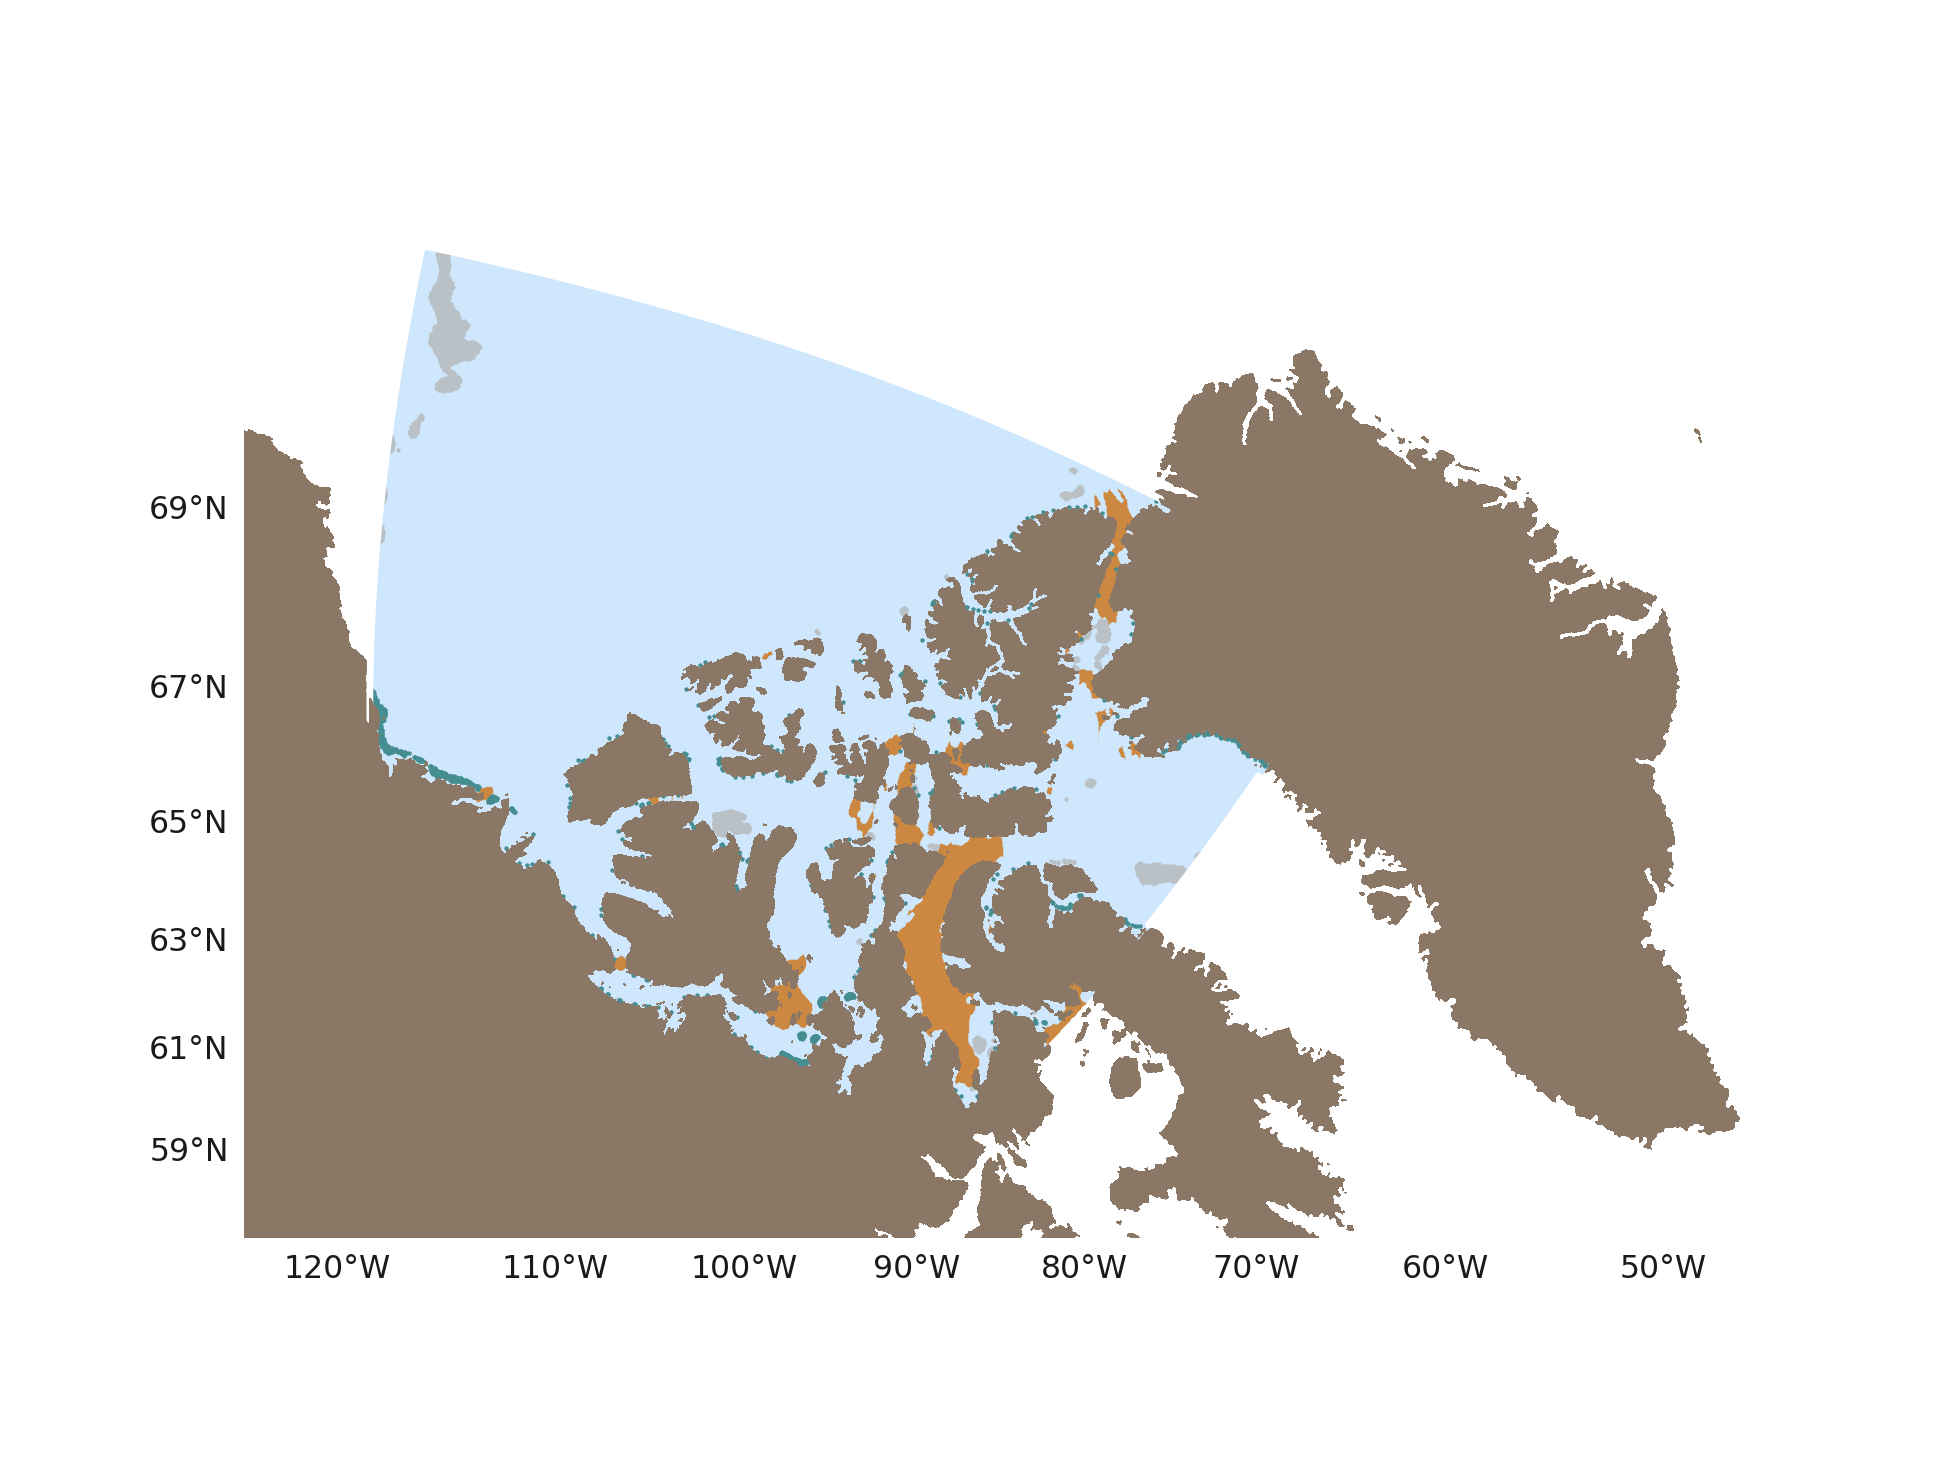

In [47]:
fig, ax1, proj1 = pickle.load(open('/ocean/brogalla/GEOTRACES/pickles/mn-reference.pickle','rb'))

x, y = proj1(lons, lats)
    
riv_imp, sed_imp, sice_imp, red_imp, ice_imp, atm_imp = comp_importance(0) #month
        
sz = 1
    
proj1.plot(x[~atm_imp.mask], y[~atm_imp.mask],'p'  , markersize=sz, c=colors[0], zorder=2)
proj1.plot(x[~red_imp.mask], y[~red_imp.mask],'p'  , markersize=sz, c=colors[2], zorder=2)
proj1.plot(x[~sed_imp.mask], y[~sed_imp.mask],'p'  , markersize=sz, c=colors[3], zorder=2)
proj1.plot(x[~ice_imp.mask], y[~ice_imp.mask],'p'  , markersize=sz, c=colors[4], zorder=2)
proj1.plot(x[~sice_imp.mask], y[~sice_imp.mask],'p', markersize=sz, c=colors[5], zorder=2)
proj1.plot(x[~riv_imp.mask], y[~riv_imp.mask],'p'  , markersize=sz, c=colors[1], zorder=2)

proj1.plot(x[-1,300:-1], y[-1,300:-1], '-w', linewidth=3)
proj1.plot(x[0,360:500], y[0,360:500], '-w', linewidth=3)
proj1.plot(x[150:-1,-1], y[150:-1,-1], '-w', linewidth=3)
        
proj1.contourf(x, y, land_mask[0,:,:], vmax=0.3, cmap=matplotlib.colors.ListedColormap(["#8b7765"]), zorder=3)

Without considering reduction:

### By water mass

- Polar mixed layer (0-40 m)
    - PML depth levels = 1 to 17
- Pacific/halocline water (40-300 m)
    - PW depth levels = 17 to 29
- Atlantic water (300-800 m)
    - AW depth levels = 29 to 35
- Deep water (> 800 m)
    - DW depth levels = 35-50